<a href="https://colab.research.google.com/github/SergeyHSE/LinearRegressor.github.io/blob/main/RegressionAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Analysis of descriptive statistics
2. Estimating a regression model under the assumptions of a classical linear regression model (CLRM)
3. Estimation of regression model under deviations from CERM assumptions:
 - Diagnosis of single atypical observations
 - Diagnosis of sample homogeneity
 - Diagnostics of specification errors and model correction when they are detected
 - Diagnosis of multicollinearity and model correction when it is detected
 - Diagnosis of heteroscedasticity and model correction when it is detected
 - Diagnosis of endogeneity and model correction when it is detected


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.diagnostic as dg
import scipy.stats
from scipy.stats import boxcox

When studying the literature on this topic, the most interesting articles were "Economic efficiency of beef cattle production in Thailand" by Professor Suneeporn Suwanmaneepong of King Mongkut's Institute of Technology Ladkrabang Faculty of Agricultural Technology PhD and "Assessment of technical efficiency and its determinants in beef cattle production in Kenya" by Eric Ruto of Lincoln University. In this paper, the professor describes the economic efficiency of livestock production. To build the model she uses the following variables as the most efficient ones: cost of feed and additives, equipment, drugs and labor, access to priority markets, etc. Unfortunately, our data do not contain information on the costs of purchasing veterinary drugs, so we will not be able to analyze their impact on the profitability of the enterprise. Therefore, we will do something else: we will deduct from the cost price all the cost items that we have. This will give us the amount including the costs of veterinary drugs.

Moreover, both authors conclude in the conclusions of their studies that there is a need for government intervention with different types of assistance such as:
- Improving farmers' access to the knowledge they need to develop their farms as well as their farming skills
- Providing access to more modern technologies
- Improving access to market services
- Creating opportunities for off-farm income generation.

All these factors are in one way or another related to government support, to a certain type of subsidy, which directly, according to the authors, should improve profit margins, and therefore improve the model's performance.


In [2]:
from google.colab import files
file = files.upload()

Saving agro_census.dta to agro_census.dta


In [3]:
data = pd.read_stata('agro_census.dta')
data.columns, data.shape

(Index(['NPPP', 'COD_COATO', 'KFS', 'KOPF', 'OKVED', 'land_total',
        'cost_milk_KRS', 'cost_KRS_food', 'cost_meat_KRS', 'AB_1', 'CF_1',
        'short_credit', 'long_credit', 'debit_debt', 'credit_debt',
        'gov_sup_plant', 'gov_sup_seed', 'gov_sup_grain', 'subs_plant',
        'subs_grain', 'gov_sup_farming', 'gov_sup_KRS', 'subs_prod_farm',
        'subs_milk', 'subs_meat', 'subs_KRS', 'subs_combikorm', 'sub_chemistry',
        'subs_fuel', 'farms_number', 'profit_farms_number',
        'unprofit_farms_number', 'capital', 'profit', 'unprofit', 'J', 'O',
        'empl_org', 'empl_prod', 'V', 'W', 'X', 'AN', 'AO', 'AP', 'AQ', 'AR',
        'BE', 'BF', 'BG', 'BQ', 'BR', 'BS', 'BT', 'BU', 'BY', 'BZ', 'CA',
        'salary_plant', 'salary_farm', 'DB', 'DC', 'DF', 'DG', 'DH', 'DI', 'DK',
        'DO', 'DT', 'EC', 'EG', 'EJ', 'EK', 'ER', 'ES', '_merge'],
       dtype='object'),
 (6287, 76))

In [4]:
df = data[(data['OKVED'] == '01.21')]
df.shape

(2595, 76)

In [5]:
df['net_profit'] = df['profit'] - df['unprofit']
df['other_cost'] = df['DG'] - df['salary_farm'] - df['DC'] - df['DI']
df['subsidies'] = df['gov_sup_KRS'] + df['subs_prod_farm'] + df['subs_milk'] + df['subs_KRS'] + df['subs_combikorm'] + df['subs_fuel']
df['debt'] = df['credit_debt'] - df['debit_debt']
df['cost_services'] = df['J'] - df['O']

<ipython-input-5-03ca306c6d52>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['net_profit'] = df['profit'] - df['unprofit']
<ipython-input-5-03ca306c6d52>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['other_cost'] = df['DG'] - df['salary_farm'] - df['DC'] - df['DI']
<ipython-input-5-03ca306c6d52>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [6]:
df.rename(columns={'DC' : 'amortization',
                   'DI' : 'social_cost'}, inplace=True)
df['output'] = df['AP'] + df['BE'] + df['BS']

<ipython-input-6-d2f9976e03fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'DC' : 'amortization',
<ipython-input-6-d2f9976e03fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['output'] = df['AP'] + df['BE'] + df['BS']


In [7]:
column_names = ['net_profit', 'other_cost', 'subsidies', 'debt',
                'cost_services', 'amortization', 'output', 'salary_farm',
                'empl_org', 'KOPF', 'social_cost']
livestock = df[column_names]
livestock.shape

(2595, 11)

We ended up with the following variables:
 - net_profit (thousand rub) - net profit of livestock production.
 - other_cost (thousand rub) - costs, which include, among other things, costs for repayment of loans and for purchase of veterinary drugs, cost for fuil, electricity and so on.
 - social_cost (thousand rub) - deductions for social needs.
 - subsidies (thousand rub) - total amount of subsidies, including subsidies for milk and meat production, fuel subsidies, etc.
 - debt (thousand rub) - current short-term debts (difference between accounts payable and accounts receivable).
 - cost_services (thousand rub) - cost_services - cost of sold goods, products, works, services (industrial products, goods, works and services).
 - amortization (thousand rub) - amortization.
 - output (centner) - gross output of milk, meat, cattle.
 - salary_farm (thousand rub) - labor costs.
 - empl_org (number of employees) - Average annual number of employees of the agricultural organization.
 - KOPF - (42
Unitary enterprises, based on the right of economic management;
47
Open joint stock companies;
52
Production cooperatives;
65
Limited liability companies;
67
Closed joint-stock companies;
54
Collective farms;
55
State farms.)

In [ ]:
livestock.head()

,net_profit,other_cost,subsidies,debt,cost_services,amortization,output,salary_farm,empl_org,KOPF,social_cost
0,8931.0,41323.0,3892.0,26477.0,13232.0,2114.0,2693.0,8735.0,294,47,1147
1,2495.0,19419.0,3710.0,11271.0,1719.0,582.0,1678.0,3827.0,166,52,490
2,98.0,24399.0,4096.0,18952.0,5407.0,572.0,3043.0,6790.0,235,67,1014
3,-4868.0,5718.0,207.0,10718.0,1254.0,162.0,668.0,1432.0,95,52,182
6,-3457.0,12246.0,825.0,3060.0,8019.0,0.0,332.0,1645.0,136,67,210


In [ ]:
# Calculate NaN
livestock.isnull().sum()

net_profit       0
other_cost       0
subsidies        0
debt             0
cost_services    0
amortization     0
output           0
salary_farm      0
empl_org         0
KOPF             0
social_cost      0
dtype: int64

In [ ]:
# Calculate zeros
(livestock == 0).sum()

net_profit        25
other_cost        77
subsidies        249
debt              25
cost_services    275
amortization     154
output           101
salary_farm       82
empl_org           0
KOPF               0
social_cost       90
dtype: int64

In [8]:
livestock = livestock.loc[~(livestock == 0).all(axis=1)]
livestock.shape

(2595, 11)

In [ ]:
(livestock < 0).sum()

net_profit       469
other_cost         0
subsidies          0
debt             380
cost_services      0
amortization       0
output             0
salary_farm        0
empl_org           0
KOPF               0
social_cost        0
dtype: int64

In [ ]:
livestock.describe()

,net_profit,other_cost,subsidies,debt,cost_services,amortization,output,salary_farm,empl_org,KOPF,social_cost
count,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000
mean,7841.578343,25980.056262,4313.216817,14084.024663,4259.199615,1647.998073,2848.882312,7750.120617,152.261657,55.442389,1179.604239
std,26857.090812,35396.334481,8416.003095,49316.495885,13197.489220,2661.216427,7633.231854,9493.783825,129.003540,8.535656,1579.778162
min,-117594.000000,0.000000,0.000000,-642913.000000,0.000000,0.000000,0.000000,0.000000,1.000000,42.000000,0.000000
25%,134.500000,7952.500000,510.500000,916.000000,290.000000,224.000000,629.000000,2532.000000,81.000000,52.000000,323.000000
50%,2889.000000,16692.000000,1669.000000,5085.000000,1123.000000,742.000000,1292.000000,5323.000000,125.000000,52.000000,710.000000
75%,9903.000000,31897.000000,4685.000000,15042.000000,3432.000000,1900.000000,2368.000000,9783.000000,189.500000,65.000000,1476.000000
max,732684.000000,907368.000000,163506.000000,842063.000000,330164.000000,32719.000000,120690.000000,225988.000000,2251.000000,67.000000,27666.000000


Thus we got the average company based on 2595 observations that the average net profit is 7842 thousand rubles with a high standard deviation of 26857 thousand rubles, while the most unprofitable company is the company with a net profit of -117594 thousand rubles, and the most profitable company has a profit of 732684 thousand rubles. The difference between the richest companies and 75% of other companies is also visible.

We can see that enterprises are heavily indebted. This is reflected in two variables: the difference between accounts payable and accounts receivable (debt) and costs, which include the costs of loan repayment (other_cost). At the same time, there are companies in which accounts receivable significantly prevail over accounts payable (this is evident from the negative value of -642913 thousand rubles).

In general, if we look at all variables, we can see that the sample is very heterogeneous. This is evidenced by high standard deviations and the difference between the values of 75% of all enterprises and the maximum values.

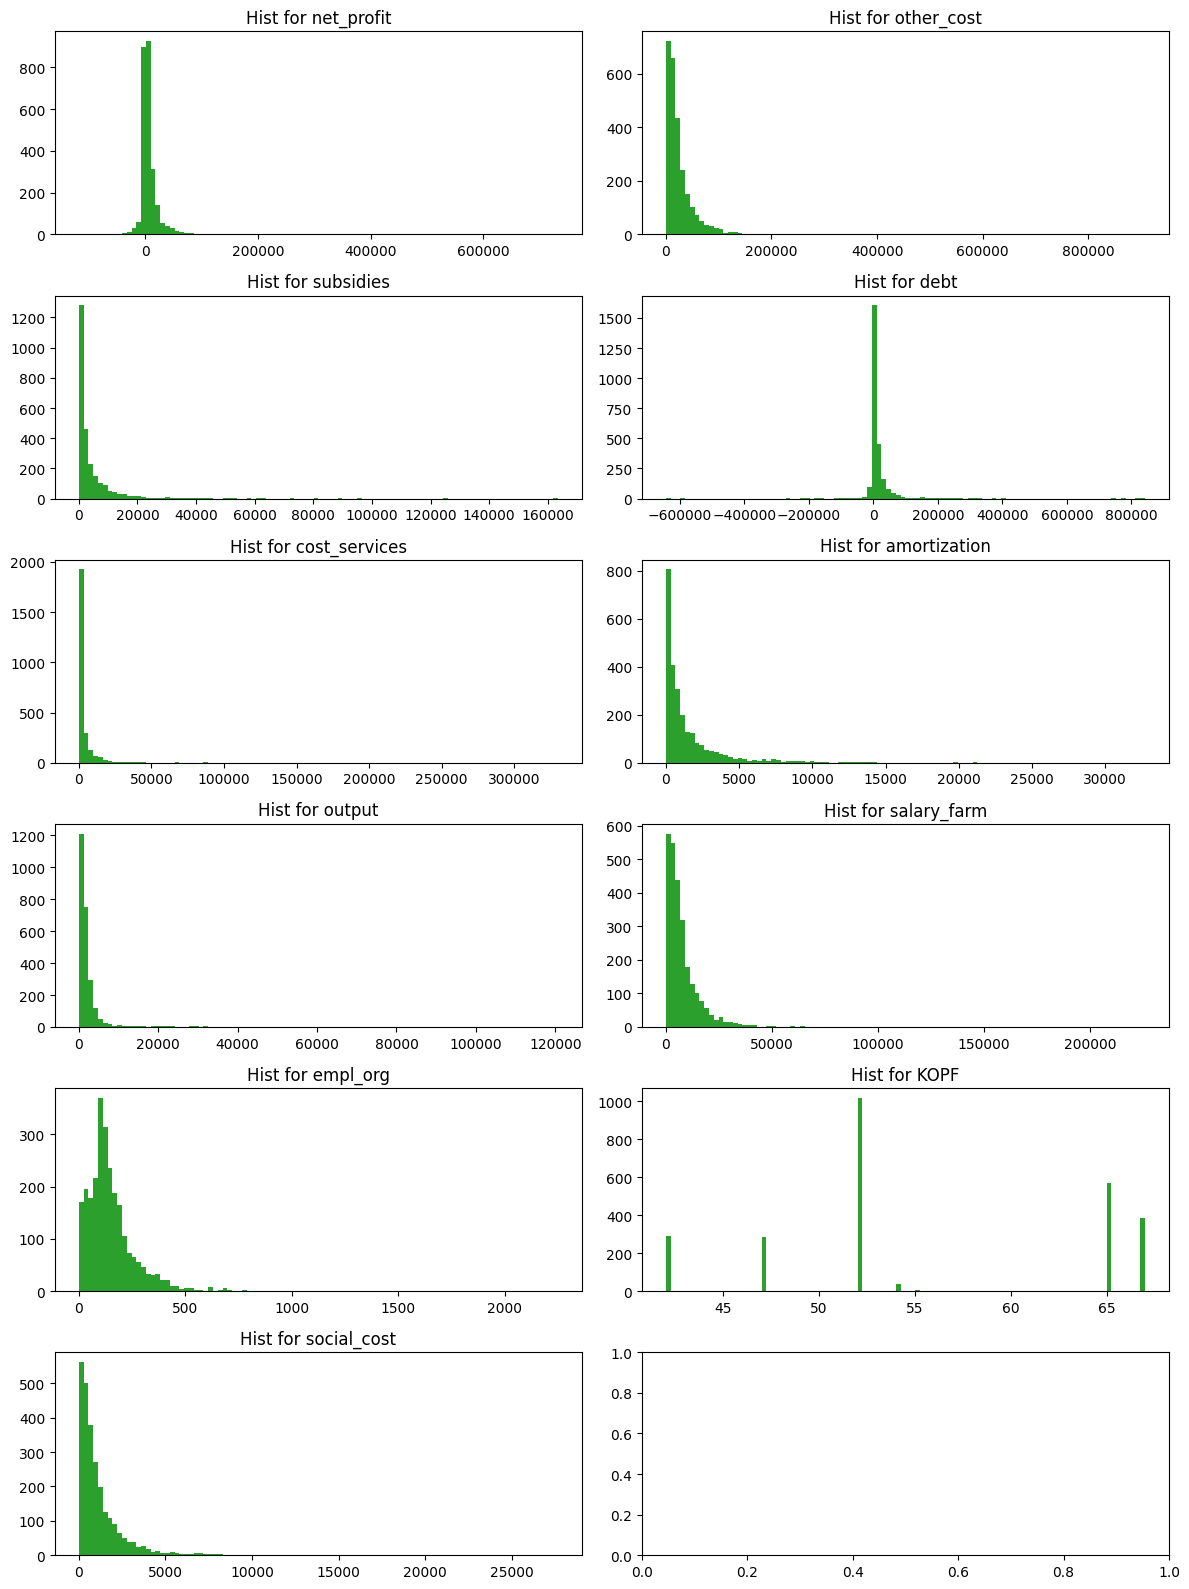

In [12]:
feature_names = list(livestock.columns)
num_rows = 6
num_cols = 2
num_plots = len(feature_names)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12,16), dpi=100)
axes = axes.flatten()

for i in range(num_plots):
  if i < num_plots:
    ax = axes[i]
    feature_data = livestock[feature_names[i]]
    ax.hist(x=feature_data, bins=100, color='tab:green')
    ax.set_title(f'Hist for {feature_names[i]}')
  else:
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

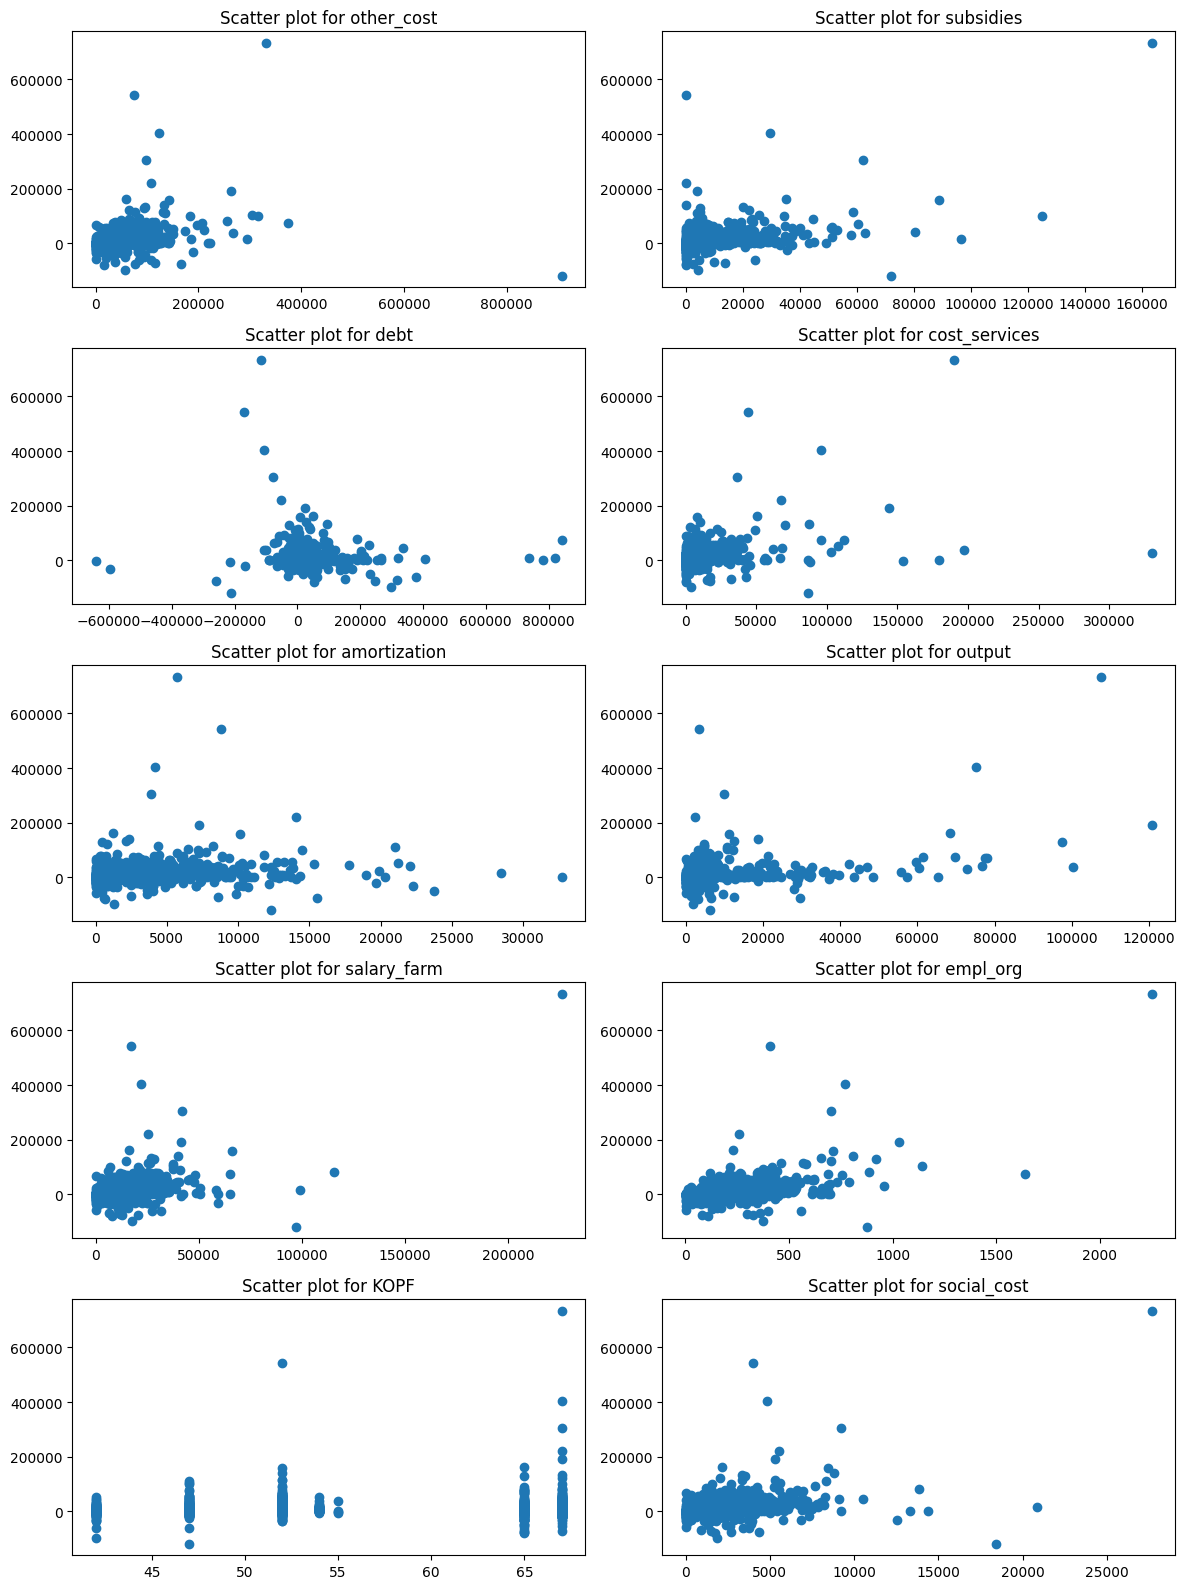

In [14]:
y = livestock['net_profit']
X = livestock.drop('net_profit', axis=1)

feature_names = list(X.columns)
num_rows = 5
num_plots = len(feature_names)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 16), dpi=100)
axes = axes.flatten()

for i in range(num_plots):
  if i < num_plots:
    ax = axes[i]
    feature_data = X[feature_names[i]]
    ax.scatter(x=feature_data, y=y, marker='o')
    ax.set_title(f'Scatter plot for {feature_names[i]}')
  else:
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()